# Libraries

In [1012]:
import pandas as pd
import numpy as np
import pickle

import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

# Data Download

In [805]:
df = pd.read_csv ('28.6 df_out.csv')
print (df.shape)
df.head(1)

(10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.06,-85.25,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00


In [806]:
# В задании перечисленны 27 признаком, тогда как в реальном датасете их только 20
# Отсутствуют: condition, cylinders, VIN, drive, size, type, paint_color, county
# Присутствует дополнительно сверх задания: date

a=0
for i in df.columns.to_list():
    a+=1
    print (f'{a} признак: {i}, уникальных: {df[i].nunique(dropna=False)}, значений nan: {len(df[df[i].isna()])}')

1 признак: id, уникальных: 10000, значений nan: 0
2 признак: url, уникальных: 10000, значений nan: 0
3 признак: region, уникальных: 393, значений nan: 0
4 признак: region_url, уникальных: 405, значений nan: 0
5 признак: price, уникальных: 2227, значений nan: 0
6 признак: year, уникальных: 90, значений nan: 36
7 признак: manufacturer, уникальных: 40, значений nan: 0
8 признак: model, уникальных: 3467, значений nan: 128
9 признак: fuel, уникальных: 6, значений nan: 63
10 признак: odometer, уникальных: 6939, значений nan: 0
11 признак: title_status, уникальных: 7, значений nan: 166
12 признак: transmission, уникальных: 4, значений nan: 45
13 признак: image_url, уникальных: 9082, значений nan: 2
14 признак: description, уникальных: 9846, значений nan: 2
15 признак: state, уникальных: 51, значений nan: 0
16 признак: lat, уникальных: 5050, значений nan: 98
17 признак: long, уникальных: 5083, значений nan: 98
18 признак: posting_date, уникальных: 9958, значений nan: 2
19 признак: price_catego

# Data Preparation

1. Произведите преобразование типов данных
2. Исследуйте данные на пропуски, дубликаты, обработайте их
3. Избавьтесь от аномалий
4. Используйте визуализацию, декомпозируйте блок на подблоки

## Dtypes

In [807]:
df1 = df.copy()

In [808]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [809]:
df1.price = df1.price.astype(float)
df1.date = pd.to_datetime(df1.date, utc = True)
df1.posting_date = pd.to_datetime(df1.posting_date, utc = True)

df1[['price','date','posting_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   price         10000 non-null  float64            
 1   date          9998 non-null   datetime64[ns, UTC]
 2   posting_date  9998 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 234.5 KB


## Dtype: df.year

In [810]:
# Для преобразования year в int необходимо сначала заполнить пропуски. Иначе функция pd.astype(int) не срабатывает.
# Данные для заполнения пропусков есть в признаке 'description'

print ('Пропусков в df1.year :', len(df1[df1.year.isna()]))
df1[df1.year.isna()].description

Пропусков в df1.year : 36


344     2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...
420     2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...
425     2019 *Dodge* *Grand Caravan* SE - $43,900Call ...
702     2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...
893     2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...
906     2020 *Honda* *Odyssey* EX-L w/Navi/RES Automat...
1005    2019 *Dodge* *Grand Caravan* SE - $38,900Call ...
1217    2019 *Honda* *CR-V* EX 2WD SUV - $24,975Call o...
1319    2018 *Toyota* *Sienna* LE Automatic Access Sea...
1845    2020 *Ford* *Transit Cargo Van* T-250 148" WB*...
2292    2019 *Toyota* *Camry* XSE Automatic Sedan - $2...
2504    2019 *Dodge* *Grand Caravan* SE - $43,900Call ...
2629    Chevrolet Impala  * AUCTION PRICES TO THE PUBL...
2819    2019 *GMC* *Acadia* AWD 4dr SLT w/SLT-1 SUV - ...
2959    2018 *Nissan* *Maxima* SR 3.5L Midnight Editio...
3294    2018 *Jeep* *Grand Cherokee* High Altitude 4x2...
3509    2020 *Ram* *3500* RAM 3500 DUALLY 4X4 CUMMINS ...
3521    2020 *

In [811]:
df1['year_from_description'] = df1.description.str.split(' ').str[0]
df1[df1.year.isna()].year_from_description

344          2019
420          2020
425          2019
702          2019
893          2020
906          2020
1005         2019
1217         2019
1319         2018
1845         2020
2292         2019
2504         2019
2629    Chevrolet
2819         2019
2959         2018
3294         2018
3509         2020
3521         2020
3671         2019
4220         2020
6120         2018
6196         2020
6323         2020
6728          NaN
7200         2018
7652         2021
7815         2019
7819         2019
8527         2020
8805         2019
9330         2019
9388          NaN
9549         2020
9723         2019
9849         2019
9953         2020
Name: year_from_description, dtype: object

In [812]:
# Т.к. год выпуска - чувствительный признак для таргета, то пустые значения, 
# которые не удается заполнить, исходя из данных по другим признакам, лучше удалить 
# (при условии, что количество таких удалений не будет большим)

df1.year = df1.year.fillna(df1.year_from_description)
df1 = df1.drop(columns='year_from_description') #сразу убираем технический признак

df1[(df1.year.isna() | (df1.year == 'Chevrolet'))].year #включаем в выборку сгенерированный вброс

2629    Chevrolet
6728          NaN
9388          NaN
Name: year, dtype: object

In [813]:
df1 = df1[~(df1.year.isna() | (df1.year == 'Chevrolet'))]
print (df1.shape)

(9997, 20)


In [814]:
#Изменение типа данных df1.year и проверка всех измененных типов по 4 признакам
df1.year = df1.year.astype(int)
df1[['price','date','posting_date', 'year']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   price         9997 non-null   float64            
 1   date          9997 non-null   datetime64[ns, UTC]
 2   posting_date  9997 non-null   datetime64[ns, UTC]
 3   year          9997 non-null   int32              
dtypes: datetime64[ns, UTC](2), float64(1), int32(1)
memory usage: 351.5 KB


## Empty cells

<AxesSubplot:>

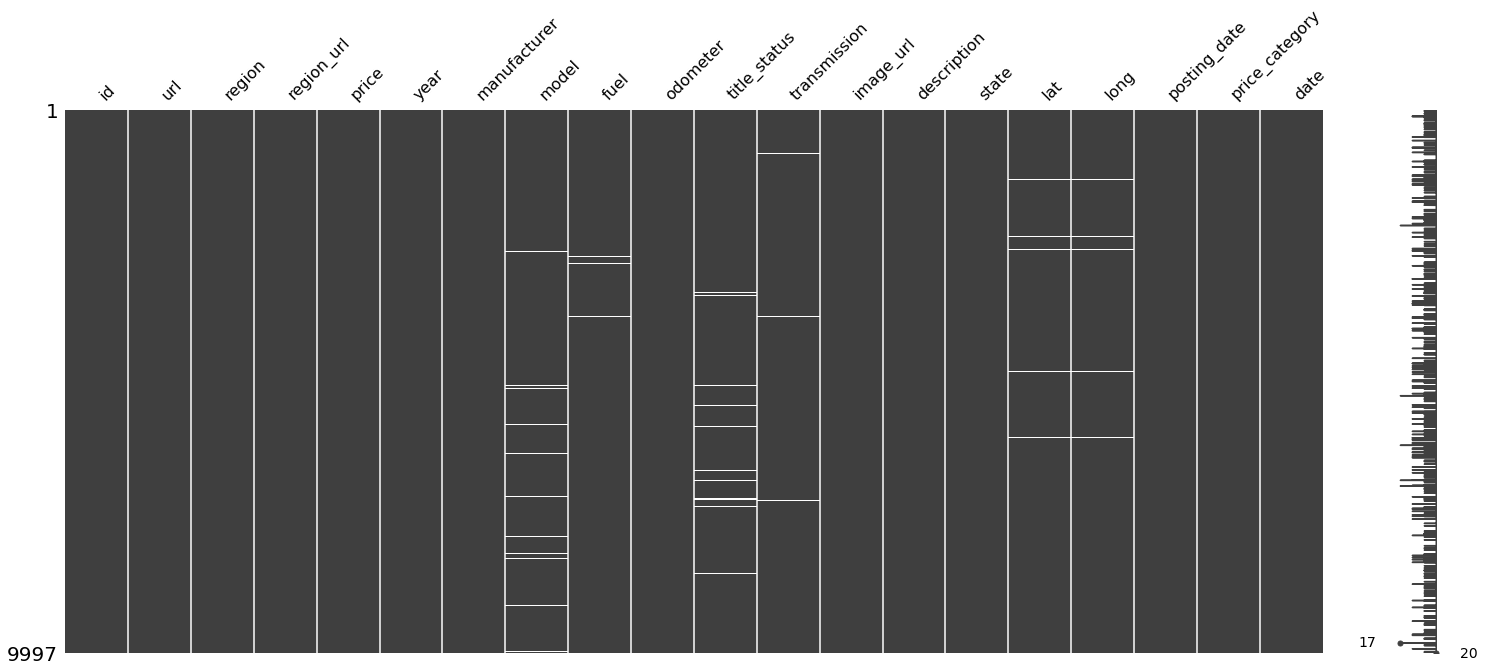

In [815]:
df1 = df1.drop_duplicates()
msno.matrix (df1)

In [816]:
print (f'Количество полностью заполненных объектов {len(df1.dropna())}')
print (f'Процент полностью заполненных объектов от всей выборки {round(len(df1.dropna()) / len(df1) * 100, 2)}%')
print ('Процент пропущенных значений по признакам:\n')

def missing_values(df1):
    return round((df1.isna().sum() / len(df1)) * 100, 2).sort_values(ascending=False)

missing_values(df1)

Количество полностью заполненных объектов 9529
Процент полностью заполненных объектов от всей выборки 95.32%
Процент пропущенных значений по признакам:



title_status      1.64
model             1.26
long              0.96
lat               0.96
fuel              0.61
transmission      0.43
price_category    0.00
posting_date      0.00
state             0.00
description       0.00
image_url         0.00
id                0.00
url               0.00
odometer          0.00
manufacturer      0.00
year              0.00
price             0.00
region_url        0.00
region            0.00
date              0.00
dtype: float64

In [817]:
# Здесь заполняем модой
df1.title_status = df1.title_status.fillna(df1.title_status.mode()[0])

# Вот это не лучшее решение.
# В обучении предлагалось через split разделить desription и прогнать через словарь значений model. 
# Но этот громоздкий вариант заменялся на простановку 'other'. Так как речь о заполнении 1,26%, то поступаю также.
df1.model = df1.model.fillna('other')

# Здесь заполняем значением 'other', т.к. такое значение уже присутствует в сете.
df1.fuel = df1.fuel.fillna('other')
df1.transmission = df1.transmission.fillna('other')


# Убиваем записи с пропусками меньше 1%
df1 = df1[~(df1.long.isna() | df1.lat.isna())]

print (df1.shape)
print (f'Процент полностью заполненных объектов от всей выборки {round(len(df1.dropna()) / len(df1) * 100, 2)}%')
print (f'Сжатие датасета после обработки пропусков: {round((len(df) - len(df1)) / len(df) * 100, 2)} % (удалено {len(df) - len(df1)} записей)')

(9901, 20)
Процент полностью заполненных объектов от всей выборки 100.0%
Сжатие датасета после обработки пропусков: 0.99 % (удалено 99 записей)


## Outliers

Text(0.5, 0.98, 'Outliers')

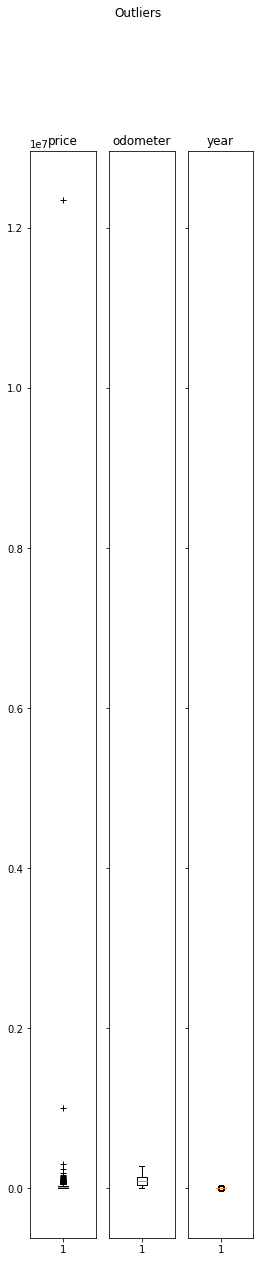

In [818]:
# На выбросы проверяем количественные параметры: price, year, odometer
# Ящик с усами не принимает datetime, поэтому posting_date и date проверим статистически

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(4, 20), sharey=True)

ax1.boxplot(df1.price, sym='+') #Аномалии есть
ax1.set_title('price')

ax2.boxplot(df1.odometer) #Аномалий нет
ax2.set_title('odometer')

ax3.boxplot(df1.year) #Для года масштаб слишком мелкий, поэтому ниже отдельный усатый ящик
ax3.set_title('year')

fig.suptitle('Outliers')

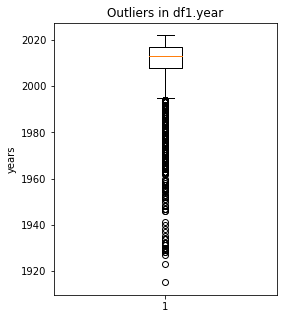

In [819]:
plt.figure (figsize = (4, 5))
plt.boxplot (df1.year) #Аномалии видны
plt.ylabel ('years')
plt.title ('Outliers in df1.year'); 

In [820]:
def boundaries (data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [821]:
# Выявление аномалий статистически

price_scopes = boundaries(df1.price)
price_outliers = (df1['price'] < price_scopes[0]) | (df1['price'] > price_scopes[1])
print ('price_outliers: ', price_outliers.sum())

odometer_scopes = boundaries(df1.odometer)
odometer_outliers = (df1['odometer'] < odometer_scopes[0]) | (df1['odometer'] > odometer_scopes[1])
print ('odometer_outliers: ', odometer_outliers.sum())

year_scopes = boundaries(df1.year)
year_outliers = (df1['year'] < year_scopes[0]) | (df1['year'] > year_scopes[1])
print ('year_outliers:',year_outliers.sum())

posting_date_scopes = boundaries(df1.posting_date)
posting_date_outliers = (df1['posting_date'] < posting_date_scopes[0]) | (df1['posting_date'] > posting_date_scopes[1])
print ('posting_date:',posting_date_outliers.sum())

date_scopes = boundaries(df1.date)
date_outliers = (df1['date'] < date_scopes[0]) | (df1['date'] > date_scopes[1])
print ('date:', date_outliers.sum())

price_outliers:  215
odometer_outliers:  0
year_outliers: 394
posting_date: 0
date: 0


In [822]:
# Корректировка аномалий price

#Видно, что аномалии цены только выше верхней границы
print ('Аномалии цены ниже нижнего порога :', len (df1[(df1['price'] < price_scopes[0])]))
df1.loc [price_outliers, 'price'] = float(price_scopes[1])

# Проверка
price_outliers = (df1['price'] < price_scopes[0]) | (df1['price'] > price_scopes[1])
print ('price_outliers после корректировки: ', price_outliers.sum())

Аномалии цены ниже нижнего порога : 0
price_outliers после корректировки:  0


In [823]:
# Корректировка аномалий year
# Аномалии года только ниже нижней границы (четко видно на графике)
df1.loc [year_outliers, 'year'] = int (year_scopes[0]) 

# Проверка
year_outliers = (df1['year'] < int (year_scopes[0])) | (df1['year'] > year_scopes[1])
print ('year_outliers после корректировки:',year_outliers.sum())

year_outliers после корректировки: 0


# Feature Engineering

1. Подготовьте категориальные переменные с помощью OneHotEncoder;
2. Стандартизируйте и нормализуйте переменные;
3. Создайте новые признаки (на основе дат, текстовых значений переменных, и т.д.);
4. Удалите неинформативные колонки, возникшие в результате Feature engineering;
5. Сформируйте финальный датасет для моделирования, сохраните его в файл.
6. Используйте визуализацию в виде графиков, таблиц, матриц корреляций.
7. Декомпозируйте блок на подблоки.

## Correlations

In [824]:
# Слабая корреляция: 
# 1. price - odometer
# 2. price - year
# 3. year - odomete

df1.corr()

,id,price,year,odometer,lat,long
id,1.000000,-0.091476,-0.098946,0.048461,-0.077969,-0.107094
price,-0.091476,1.000000,0.532254,-0.531314,-0.014030,-0.078173
year,-0.098946,0.532254,1.000000,-0.501498,-0.033195,0.006630
odometer,0.048461,-0.531314,-0.501498,1.000000,0.025809,0.009387
lat,-0.077969,-0.014030,-0.033195,0.025809,1.000000,-0.163623
long,-0.107094,-0.078173,0.006630,0.009387,-0.163623,1.000000


## New Features

In [872]:
df2 = df1.copy()

In [873]:
# region_new, извлеченный из url
df2['region_new'] = df2.region_url.apply(lambda x: x.lower().split('://')[1].split('.')[0])
print ('region.nunique:', df2.region.nunique(), 'region_new.nunique:', df2.region_new.nunique())
print ('inconsistency:', len(df2[df2['region'] != df2['region_new']]))

df2['region_new'].unique()

region.nunique: 393 region_new.nunique: 405
inconsistency: 5358


array(['chattanooga', 'newjersey', 'reno', 'fayetteville', 'newyork',
       'knoxville', 'desmoines', 'roanoke', 'grandrapids', 'omaha',
       'providence', 'cincinnati', 'jacksonville', 'seattle', 'redding',
       'honolulu', 'salina', 'billings', 'fresno', 'charleston',
       'inlandempire', 'madison', 'modesto', 'southjersey', 'phoenix',
       'newhaven', 'fortmyers', 'easttexas', 'charlotte', 'corpuschristi',
       'appleton', 'lasvegas', 'eugene', 'kpr', 'syracuse', 'stockton',
       'danville', 'greenville', 'philadelphia', 'anchorage', 'maine',
       'porthuron', 'springfield', 'olympic', 'sanangelo', 'richmond',
       'albuquerque', 'dallas', 'sfbay', 'yakima', 'fortcollins', 'boise',
       'stcloud', 'albany', 'nashville', 'cosprings', 'yubasutter', 'slo',
       'cleveland', 'prescott', 'hudsonvalley', 'ventura', 'holland',
       'ocala', 'batonrouge', 'cnj', 'pittsburgh', 'tucson', 'ames',
       'erie', 'vermont', 'killeen', 'austin', 'jerseyshore', 'westky',
   

In [874]:
# Model_short - укороченный вариант названия (описания) модели
df2['model_short'] = df2.model.apply(lambda x: x.lower().split(' ')[0])
print (df2.model.nunique(), df2.model_short.nunique())

3457 937


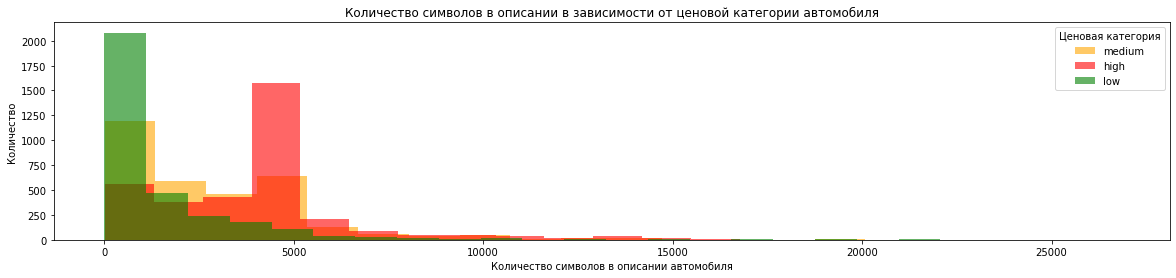

In [875]:
# Длинна описания
# Признак осмысленный: видно распределение значений по катергориям цены
df2['desc_len'] = df2.apply(lambda x: len(x.description) , axis=1)

colors = {'medium': 'orange', 'high': 'red', 'low': 'green',}

fig, ax = plt.subplots(figsize=(20, 4))
for price_category in colors:
    color = colors[price_category]
    data = df2[df2['price_category'] == price_category]

    ax.hist(data['desc_len'], color=color, alpha=0.6, bins=20)
    
plt.ylabel('Количество')
plt.xlabel('Количество символов в описании автомобиля')
plt.title('Количество символов в описании в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

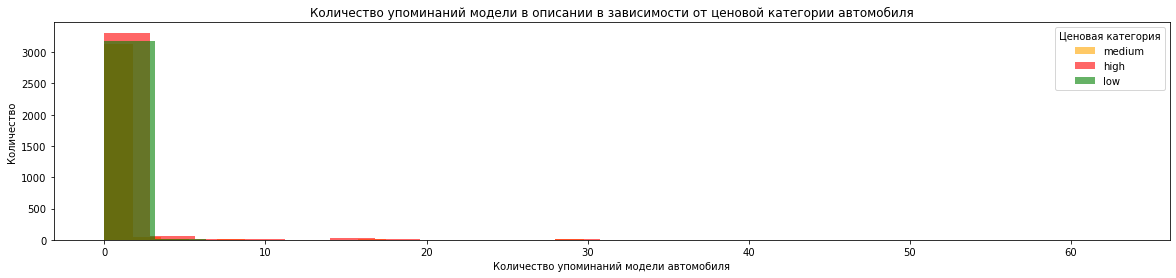

In [876]:
# Количество упоминаний модели в описании
# Признак бессмысленный
df2['model_in_desc'] = df2.apply(lambda x: x.description.count(x.model) , axis=1)

colors = {'medium': 'orange', 'high': 'red', 'low': 'green',}

fig, ax = plt.subplots(figsize=(20, 4))
for price_category in colors:
    color = colors[price_category]
    data = df2[df2['price_category'] == price_category]

    ax.hist(data['model_in_desc'], color=color, alpha=0.6, bins=20)
    
plt.ylabel('Количество')
plt.xlabel('Количество упоминаний модели автомобиля')
plt.title('Количество упоминаний модели в описании в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

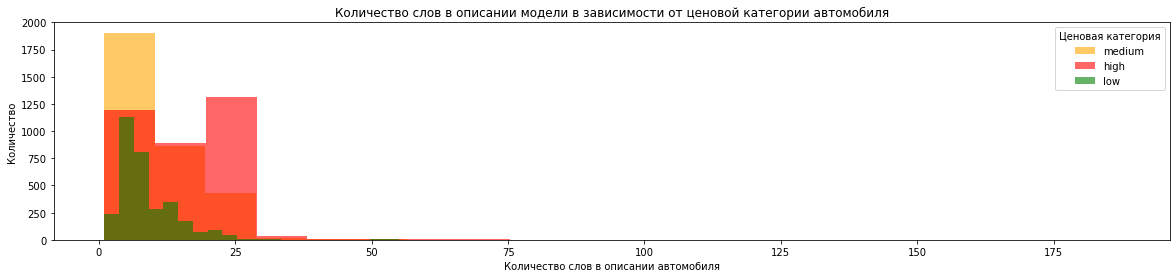

In [877]:
# Длинна описания модели
# Видно распределение по категориям цены
df2['model_len'] = df2.apply(lambda x: len(x.model), axis=1)

colors = {'medium': 'orange', 'high': 'red', 'low': 'green',}

fig, ax = plt.subplots(figsize=(20, 4))
for price_category in colors:
    color = colors[price_category]
    data = df2[df2['price_category'] == price_category]

    ax.hist(data['model_len'], color=color, alpha=0.6, bins=20)
    
plt.ylabel('Количество')
plt.xlabel('Количество слов в описании автомобиля')
plt.title ('Количество слов в описании модели в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

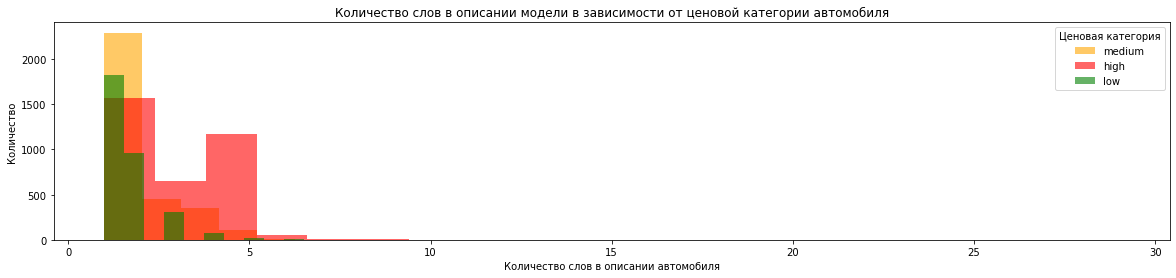

In [878]:
# Количество слов в названии(описании) модели авто
# Видно распределение по категориям цены
df2['model_word_count'] = df2.apply(lambda x: len(x.model.split(' ')), axis=1)

colors = {'medium': 'orange', 'high': 'red', 'low': 'green',}

fig, ax = plt.subplots(figsize=(20, 4))
for price_category in colors:
    color = colors[price_category]
    data = df2[df2['price_category'] == price_category]

    ax.hist(data['model_word_count'], color=color, alpha=0.6, bins=20)
    
plt.ylabel('Количество')
plt.xlabel('Количество слов в описании автомобиля')
plt.title ('Количество слов в описании модели в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

In [913]:
# df.date и df.posting_date после перевода к UTC оказались одним и тем же
df2[(df2.date != df2.posting_date)]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,long,posting_date,price_category,date,region_new,model_short,desc_len,model_in_desc,model_len,model_word_count


In [955]:
# Время с даты размещения объекта в каталоге
df2['time_lapse'] =df2.apply(lambda x: (x.date - df2.date.min()).days, axis=1)
df2.time_lapse.head()

0    13
1    29
2    24
3    13
4    29
Name: time_lapse, dtype: int64

In [957]:
#Корреляция ничтожна
df2.time_lapse.corr(df2.price)

-0.08926892811224818

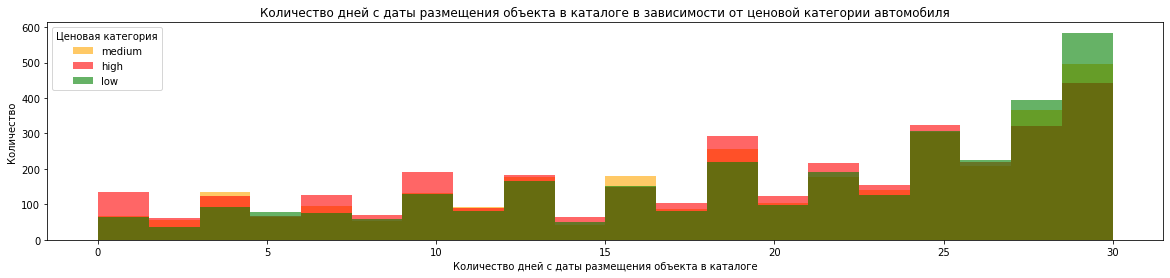

In [958]:
# Небольшая закономерность прослеживается: данные вводятся пакетно, через равные промежутки времени. 
# При этом, в последние дни вносилось больше авто категории "high", а наиболее отдаленные даты "low". 
colors = {'medium': 'orange', 'high': 'red', 'low': 'green',}

fig, ax = plt.subplots(figsize=(20, 4))
for price_category in colors:
    color = colors[price_category]
    data = df2[df2['price_category'] == price_category]

    ax.hist(data['time_lapse'], color=color, alpha=0.6, bins=20)
    
plt.ylabel('Количество')
plt.xlabel('Количество дней с даты размещения объекта в каталоге')
plt.title ('Количество дней с даты размещения объекта в каталоге в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

## OneHotEncoder

In [963]:
df3 = df2.copy()

In [964]:
df2.columns.to_list()

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'image_url',
 'description',
 'state',
 'lat',
 'long',
 'posting_date',
 'price_category',
 'date',
 'region_new',
 'model_short',
 'desc_len',
 'model_in_desc',
 'model_len',
 'model_word_count',
 'time_lapse']

In [965]:
ohe = OneHotEncoder(sparse=False)
ohe

OneHotEncoder(sparse=False)

In [966]:
# Категориальные признаки: 'manufacturer', 'fuel', 'title_status', 'transmission', 'state', 'region_new', 'model_short'

ohe.fit(df3[['manufacturer']])
ohe_manufacturer = ohe.transform (df3[['manufacturer']])
df3[ohe.get_feature_names_out()] = ohe_manufacturer

ohe.fit (df3[['fuel']])
ohe_fuel = ohe.transform (df3[['fuel']])
df3[ohe.get_feature_names_out()] = ohe_fuel

ohe.fit (df3[['title_status']])
ohe_title_status = ohe.transform (df3[['title_status']])
df3[ohe.get_feature_names_out()] = ohe_title_status

ohe.fit (df3[['transmission']])
ohe_transmission = ohe.transform (df3[['transmission']])
df3[ohe.get_feature_names_out()] = ohe_transmission

ohe.fit (df3[['state']])
ohe_state = ohe.transform (df3[['state']])
df3[ohe.get_feature_names_out()] = ohe_state

ohe.fit (df3[['region_new']])
ohe_state = ohe.transform (df3[['region_new']])
df3[ohe.get_feature_names_out()] = ohe_state

ohe.fit (df3[['model_short']])
ohe_model = ohe.transform (df3[['model_short']])
df3[ohe.get_feature_names_out()] = ohe_model

C:\Users\Ivan\AppData\Local\Temp\ipykernel_13644\4147429729.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df3[ohe.get_feature_names_out()] = ohe_state
C:\Users\Ivan\AppData\Local\Temp\ipykernel_13644\4147429729.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df3[ohe.get_feature_names_out()] = ohe_state
C:\Users\Ivan\AppData\Local\Temp\ipykernel_13644\4147429729.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

## StandardScaler

In [900]:
# Количественные признаки:
# 'odometer', 'year', 'lat', 'long', 'desc_len', 'model_len', 'model_word_count', 'time_lapse'
# 'date', 'posting_date' StandardScaler() не принимает
# 'model_in_desc' оказался бессмысленным
# 'price' имеет корреляцию '1' с таргетом

std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [967]:
std_scaler.fit(df3[['odometer', 'year', 'lat', 'long', 'desc_len', 'model_len', 'model_word_count', 'time_lapse']])
std_scaled = std_scaler.transform(df3[['odometer','year', 'lat', 'long', 'desc_len', 'model_len', 'model_word_count','time_lapse']])
df3[['scl_odometer', 'scl_year', 'scl_lat', 'scl_long', 'scl_desc_len', 'scl_model_len', 'scl_model_word_count', 'scl_time_lapse']] = std_scaled

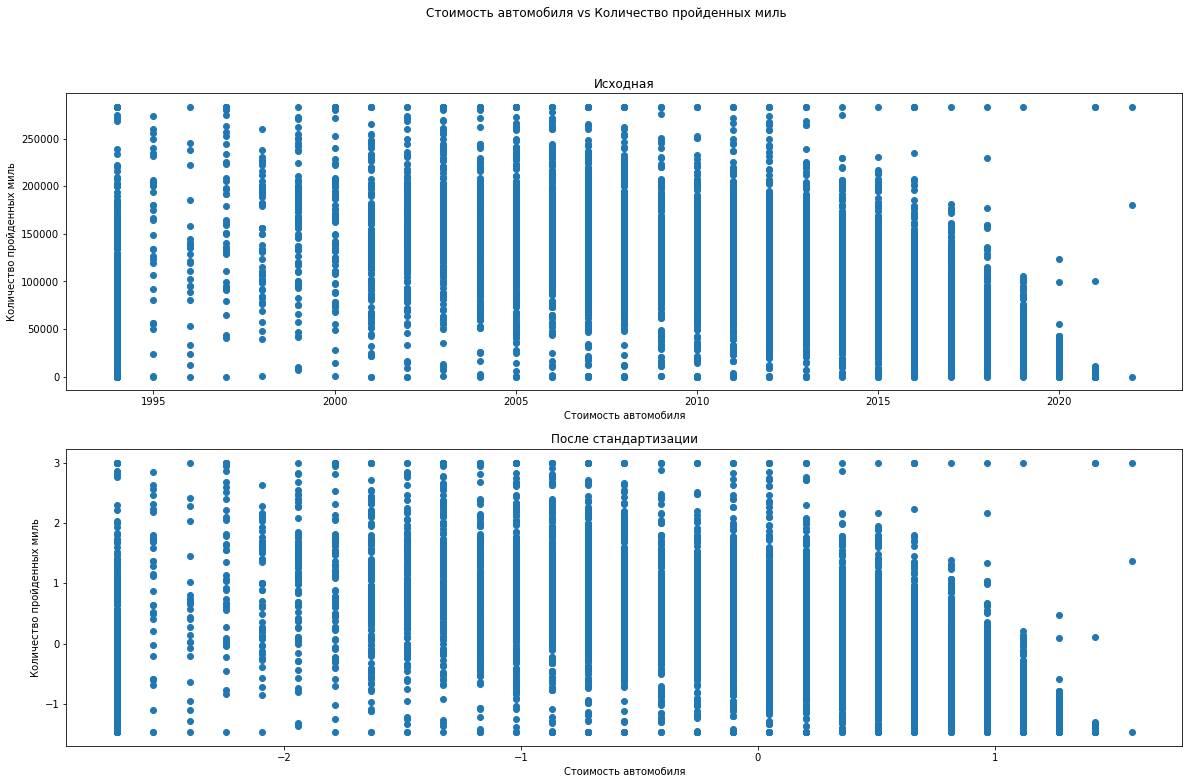

In [968]:
# Прверка результата стандартизации на 2 параметрах 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

ax1.scatter(df3.year, df3.odometer)
ax1.set_title('Исходная')
ax1.set_ylabel('Количество пройденных миль')
ax1.set_xlabel('Стоимость автомобиля')

ax2.scatter(df3.scl_year, df3.scl_odometer)
ax2.set_title('После стандартизации')
ax2.set_ylabel('Количество пройденных миль')
ax2.set_xlabel('Стоимость автомобиля')

fig.suptitle('Стоимость автомобиля vs Количество пройденных миль');

## Drop the Excessive

In [969]:
df4 = df2.drop(columns = 'price_category')
df5 = df3.drop(columns = df4.columns.to_list())
print (df5.shape)

(9901, 1456)


In [971]:
df5.to_csv('28_data_prepared.csv', sep = '\t', index = False)

# Modeling

1. сформируйте датасет для обучения; 
2. инициализируйте фичи и целевую переменную (price_category); разделите данные на train и test;
3. объявите три модели: логистическая регрессия, случайный лес и многослойный персептрон;
4. поработайте с моделями: сделайте тюнинг параметров и выберите лучшую модель с помощью кросс-валидации на тренировочной выборке;
5. по результатам кросс-валидации выберите лучшую модель;
6. посчитайте значение метрики лучшей модели на тестовой выборке; убедитесь, что модель не переобучилась.

In [972]:
df_model = pd.read_csv('28_data_prepared.csv',  sep = '\t')
df_model.shape

(9901, 1456)

In [973]:
x = df_model.drop(['price_category'], axis=1)
y = df_model['price_category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [1005]:
# Многослойный персептрон
mlp = MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes = (100, 20), activation = 'tanh')

mlp.fit(x_train, y_train)
pred_train =  mlp.predict (x_train)
pred_test = mlp.predict(x_test)

mlp_val = cross_val_score (mlp, x, y, cv=5)

print (f'accuracy_score на тренировочной выборке = {accuracy_score(y_train, pred_train)}')
print (f'результат кросс-валидации: {cross_validate (mlp, x, y, cv=5)}')
print (f'среднее 5 фолдов: {np.mean(mlp_val.tolist())}, стандартное отклонение: {np.std(mlp_val.tolist())}')

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

accuracy_score на тренировочной выборке = 0.9968253968253968


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


результат кросс-валидации: {'fit_time': array([44.4774003 , 44.94719672, 45.00762391, 45.00465059, 48.3244276 ]), 'score_time': array([0.03182173, 0.02107668, 0.03575683, 0.01952457, 0.03184319]), 'test_score': array([0.78748107, 0.78131313, 0.79141414, 0.77272727, 0.78838384])}
среднее 5 фолдов: 0.7842638908009933, стандартное отклонение: 0.006637029955043058


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [1006]:
# Логистическая регрессия
logreg = LogisticRegression(C = 10, max_iter=100, penalty='l1', solver='liblinear')

logreg.fit(x_train, y_train)
pred_train =  logreg.predict (x_train)
pred_test = logreg.predict(x_test)

logreg_val = cross_val_score (logreg, x, y, cv=5)

print (f'accuracy_score на тренировочной выборке = {accuracy_score(y_train, pred_train)}')
print (f'результат кросс-валидации: {cross_validate (logreg, x, y, cv=5)}')
print (f'среднее 5 фолдов: {np.mean(logreg_val.tolist())}, стандартное отклонение: {np.std(logreg_val.tolist())}')

accuracy_score на тренировочной выборке = 0.8673881673881674
результат кросс-валидации: {'fit_time': array([1.67413473, 1.87622643, 1.92129016, 1.7410686 , 1.55874348]), 'score_time': array([0.03402042, 0.03057384, 0.0162642 , 0.02695274, 0.03206563]), 'test_score': array([0.76224129, 0.75808081, 0.75454545, 0.75151515, 0.76363636])}
среднее 5 фолдов: 0.7581048241118913, стандартное отклонение: 0.004758472983047967


In [1007]:
# Cлучайный лес
tree = RandomForestClassifier(bootstrap = False, max_features = 'log2', n_estimators = 200)

tree.fit(x_train, y_train)
pred_train = tree.predict (x_train)
pred_test = tree.predict(x_test)

tree_val = cross_val_score (tree, x, y, cv=5)

print (f'accuracy_score на тренировочной выборке = {accuracy_score(y_train, pred_train)}')
print (f'результат кросс-валидации: {cross_validate (tree, x, y, cv=5)}')
print (f'среднее 5 фолдов: {np.mean(tree_val.tolist())}, стандартное отклонение: {np.std(tree_val.tolist())}')

accuracy_score на тренировочной выборке = 1.0
результат кросс-валидации: {'fit_time': array([15.20017934, 15.23695779, 15.18606949, 15.20572805, 15.19406414]), 'score_time': array([0.30813551, 0.30160594, 0.28892803, 0.30228209, 0.28857017]), 'test_score': array([0.77132761, 0.78282828, 0.78030303, 0.78232323, 0.77272727])}
среднее 5 фолдов: 0.7752758274313045, стандартное отклонение: 0.004394264339560139


# Results

1. Какая модель показала себя лучше всего и будет финальным результатом данного ноутбука;
2. обучите эту модель на всём датасете;
3. сохраните обученную модель в pickle.

Наиболее высокая точность предсказания у перспетрона (78,4%).
Однако случайный лес, при таком же стандартном отклонении, лишь на 0,9 % менее точен (77,5 %). 
Одновременно он работает в 3 раза быстрее персептрона. 

По совокупности ТТХ наиболее оптимальным оказывается случайный лес

In [1009]:
tree.fit(x, y)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=200)

In [1013]:
filename = '28_final_model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(tree, file)

In [1018]:
# Проверка
with open(filename, 'rb') as file:
  model_from_pickle = pickle.load(file)
model_from_pickle

row = df_model.sample(1)
row_x = row.drop(['price_category'], axis=1)
row_y = row['price_category']
model_from_pickle.predict(row_x)
row_y

9717    medium
Name: price_category, dtype: object